In [57]:
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

In [58]:
with open('kaggle.json', 'r') as f:
    data = dict(json.load(f))
    print(data['username'])

shoaib963


In [59]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data')

Skipping, found downloaded files in ".\breast-cancer-wisconsin-data" (use force=True to force download)


In [60]:
#reproducibility
seed = 33
torch.manual_seed(seed)
np.random.seed(seed)

In [61]:
df = pd.read_csv('breast-cancer-wisconsin-data/data.csv')
df.drop(['id', 'Unnamed: 32'], inplace=True, axis=1)

In [62]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [63]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)

In [65]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

In [66]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(30, 16)
        self.layer2 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

In [67]:
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [68]:
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [69]:
tr_acc = []
val_acc = []

In [70]:
num_epochs = 200
early_stopping_patience = 20
best_val_loss = float('inf')
current_patience = 0

In [71]:
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        tr_outputs = model(X_train_tensor)
        tr_predictions = (tr_outputs > 0.5).float()
        tr_accuracy = (tr_predictions == y_train_tensor).float().mean().item()
        tr_acc.append(tr_accuracy)


    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = (val_predictions == y_test_tensor).float().mean().item()
        val_acc.append(val_accuracy)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break


Early stopping at epoch 21


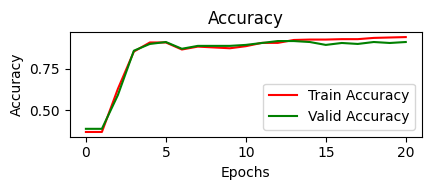

[[98  7]
 [ 8 58]]


In [75]:
# Plotting
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(range(epoch + 1), tr_acc, 'r', label='Train Accuracy')
plt.plot(range(epoch + 1), val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Prediction and evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).cpu().numpy()

cm = confusion_matrix(y_test, y_pred)
print(cm)

In [76]:
torch.save(model.state_dict(), 'shoaib_model_v1.pth')